### Interpretability - Knowledge Distillation Effects on Legal Reasoning

Question: Does distillation change how models make decisions?

Using gradient-based attribution methods (Integrated Gradients, Input×Gradient)

### Setup

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForMultipleChoice, AutoTokenizer
from data_loader import get_dataloaders
from captum.attr import IntegratedGradients, InputXGradient
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### Load models

In [ ]:
teacher_path = "results/training_runs/fine_tuned_base_bert_legal_teacher/run_lr_1e-05/checkpoint-1325"
student_path = "results/training_runs/vanilla_kd_grid_search/vanilla_L6_A0p7_T20/checkpoint-3975"

teacher_model = AutoModelForMultipleChoice.from_pretrained(teacher_path).to(device).eval()
student_model = AutoModelForMultipleChoice.from_pretrained(student_path).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

print(f"Teacher: {len(teacher_model.bert.encoder.layer)} layers")
print(f"Student: {len(student_model.bert.encoder.layer)} layers")

Teacher: 12 layers
Student: 6 layers


### Load data

In [ ]:
datasets = get_dataloaders(tokenizer, return_dict=True)
dev_dataset = datasets['dev']

# Take 10 examples for testing
n_samples = 10
dev_sample = dev_dataset.select(range(n_samples))
print(f"Sampled {len(dev_sample)} examples")

Casting the dataset: 100%|██████████| 5298/5298 [00:00<00:00, 105739.26 examples/s]

Sampled 10 examples


### Wrapper for MultipleChoice models

Captum expects models that output logits for a single input. 
MultipleChoice models expect (batch, num_choices, seq_len).

Strategy: For each example, explain the correct choice vs others

In [ ]:
def forward_func_mc(input_ids, attention_mask, model, choice_idx=0):
    """
    Forward function for MultipleChoice model that extracts logit for specific choice
    
    Args:
        input_ids: (batch, seq_len) - single choice
        attention_mask: (batch, seq_len)
        model: MultipleChoice model
        choice_idx: which choice to get logit for (0-4)
    """
    # Reshape to (batch, 1, seq_len) for MultipleChoice
    input_ids = input_ids.unsqueeze(1)
    attention_mask = attention_mask.unsqueeze(1)
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # outputs.logits is (batch, 1) since we only have 1 choice
    return outputs.logits.squeeze(1)

### Get attributions for single example

In [ ]:
def get_attributions(model, input_ids, attention_mask, method='ig'):
    """
    Get token attributions for a single input
    
    Args:
        model: the model
        input_ids: (seq_len,)
        attention_mask: (seq_len,)
        method: 'ig' or 'ixg'
    
    Returns:
        attributions: (seq_len,) numpy array
    """
    # Add batch dimension
    input_ids = input_ids.unsqueeze(0).to(device)
    attention_mask = attention_mask.unsqueeze(0).to(device)
    
    # Create forward function wrapper
    def forward_wrapper(input_embeds):
        # Reshape for MultipleChoice: (batch, 1, seq_len, hidden)
        input_embeds = input_embeds.unsqueeze(1)
        attention_mask_expanded = attention_mask.unsqueeze(1)
        
        outputs = model(
            inputs_embeds=input_embeds,
            attention_mask=attention_mask_expanded
        )
        return outputs.logits.squeeze(1)
    
    # Get embeddings - don't call through model, access embedding layer directly
    with torch.no_grad():
        embeddings = model.bert.embeddings(input_ids.squeeze(1))
    
    # Clone and detach to make it a leaf variable
    embeddings = embeddings.detach().clone()
    embeddings = embeddings.unsqueeze(0)  # (1, seq_len, hidden)
    embeddings.requires_grad = True  # Now it's a leaf, so this works
    
    # Initialize attribution method
    if method == 'ig':
        attr_method = IntegratedGradients(forward_wrapper)
        attributions = attr_method.attribute(embeddings, n_steps=50)
    else:  # ixg
        attr_method = InputXGradient(forward_wrapper)
        attributions = attr_method.attribute(embeddings)
    
    # Sum over embedding dimension
    attributions = attributions.sum(dim=-1).squeeze().detach().cpu().numpy()
    
    return attributions

### Visualize attributions through Integrated Gradients

In [ ]:
def visualize_attributions(tokens, attributions, title="Token Attributions"):
    """
    Simple text visualization of attributions
    """
    # Normalize attributions
    attr_norm = attributions / (np.abs(attributions).max() + 1e-10)
    
    print(f"\n{title}")
    print("=" * 60)
    
    for token, attr in zip(tokens, attr_norm):
        if attr > 0.1:
            print(f"[{token}] +{attr:.2f}")
        elif attr < -0.1:
            print(f"[{token}] {attr:.2f}")

In [ ]:
def plot_attribution_heatmap(tokens, teacher_attr, student_attr, max_tokens=50, title="Attribution Comparison"):
    """
    Plot side-by-side heatmap of teacher vs student attributions
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Truncate to max_tokens
    tokens = tokens[:max_tokens]
    teacher_attr = teacher_attr[:max_tokens]
    student_attr = student_attr[:max_tokens]
    
    # Normalize attributions to [-1, 1] for each model
    teacher_norm = teacher_attr / (np.abs(teacher_attr).max() + 1e-10)
    student_norm = student_attr / (np.abs(student_attr).max() + 1e-10)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Teacher heatmap
    teacher_data = teacher_norm.reshape(1, -1)
    sns.heatmap(teacher_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                xticklabels=tokens, yticklabels=['Teacher'], 
                cbar_kws={'label': 'Attribution'}, ax=ax1)
    ax1.set_title('Teacher Attributions', fontsize=12)
    ax1.set_xticklabels(tokens, rotation=90, fontsize=8)
    
    # Student heatmap
    student_data = student_norm.reshape(1, -1)
    sns.heatmap(student_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                xticklabels=tokens, yticklabels=['Student'], 
                cbar_kws={'label': 'Attribution'}, ax=ax2)
    ax2.set_title('Student Attributions', fontsize=12)
    ax2.set_xticklabels(tokens, rotation=90, fontsize=8)
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


def plot_attribution_comparison_bars(tokens, teacher_attr, student_attr, top_k=15):
    """
    Bar plot showing top-k most important tokens for both models
    """
    import matplotlib.pyplot as plt
    
    # Get top-k indices for each model
    teacher_top_idx = np.argsort(np.abs(teacher_attr))[-top_k:][::-1]
    student_top_idx = np.argsort(np.abs(student_attr))[-top_k:][::-1]
    
    # Get union of top tokens
    all_top_idx = sorted(set(teacher_top_idx) | set(student_top_idx))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(all_top_idx))
    width = 0.35
    
    teacher_vals = [teacher_attr[i] for i in all_top_idx]
    student_vals = [student_attr[i] for i in all_top_idx]
    token_labels = [tokens[i] for i in all_top_idx]
    
    ax.bar(x - width/2, teacher_vals, width, label='Teacher', alpha=0.8)
    ax.bar(x + width/2, student_vals, width, label='Student', alpha=0.8)
    
    ax.set_ylabel('Attribution Score')
    ax.set_title(f'Top-{top_k} Most Important Tokens (Combined)')
    ax.set_xticks(x)
    ax.set_xticklabels(token_labels, rotation=45, ha='right')
    ax.legend()
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
def filter_tokens_and_attributions(tokens, attributions):
    """
    Filter out special tokens, subwords, and keep only meaningful words
    
    Returns:
        filtered_tokens: list of meaningful tokens
        filtered_attr: corresponding attributions
        filtered_indices: original indices (for reference)
    """
    filtered_tokens = []
    filtered_attr = []
    filtered_indices = []
    
    for idx, (token, attr) in enumerate(zip(tokens, attributions)):
        # Skip special tokens
        if token in ['[CLS]', '[SEP]', '[PAD]', '[UNK]']:
            continue
        
        # Skip subword pieces (starting with ##)
        if token.startswith('##'):
            continue
        
        # Skip single characters (unless numbers)
        if len(token) == 1 and not token.isdigit():
            continue
        
        # Skip pure punctuation
        if all(c in '.,;:!?()[]{}"\'-/' for c in token):
            continue
        
        filtered_tokens.append(token)
        filtered_attr.append(attr)
        filtered_indices.append(idx)
    
    return filtered_tokens, np.array(filtered_attr), filtered_indices

### Test on single example

In [ ]:
example_num = 1

# Get first example
example = dev_sample[example_num] # modify this
label = example['labels'].item()

# Get correct choice
correct_input_ids = example['input_ids'][label]
correct_attn_mask = example['attention_mask'][label]

# Decode tokens
tokens = tokenizer.convert_ids_to_tokens(correct_input_ids)

print(f"Label: {label}")
print(f"Text preview: {tokenizer.decode(correct_input_ids[:100])}...")

Label: 2
Text preview: [CLS] id. at 782 - 83. the pattern requirement was given broader treatment in united states v. stofsky, 409 f. supp. 609 ( s. d. n. y. 1973 ), wherein the court construed § 1962 ( c ) and § 1961 in pari materia with the definition of [UNK] pattern of criminal conduct [UNK] stated in 18 u. s. c. § 3575, supra. concluding that § 3575 ( e ) [UNK] may be used to cast light on...



Computing teacher attributions...

Computing student attributions...

Filtered from 512 to 146 meaningful tokens


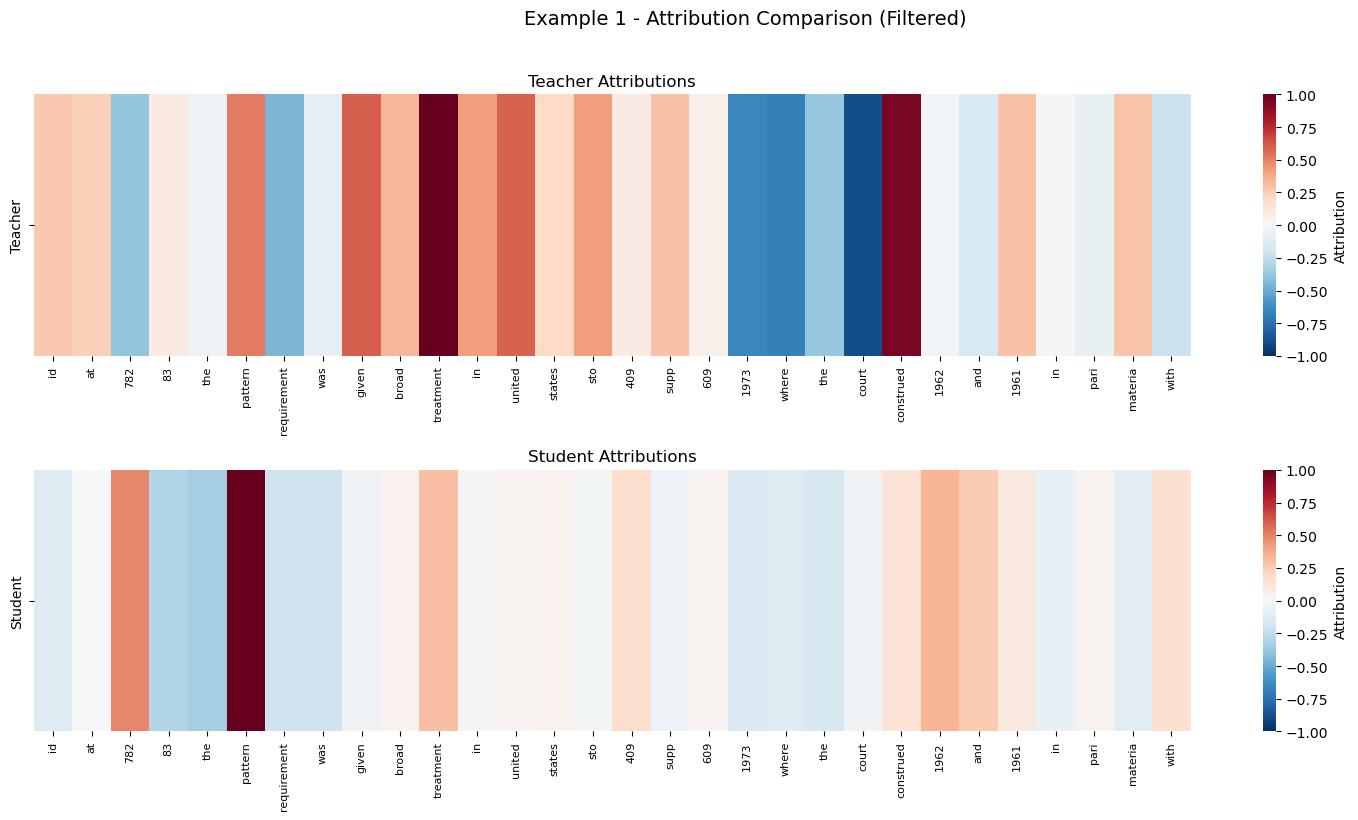

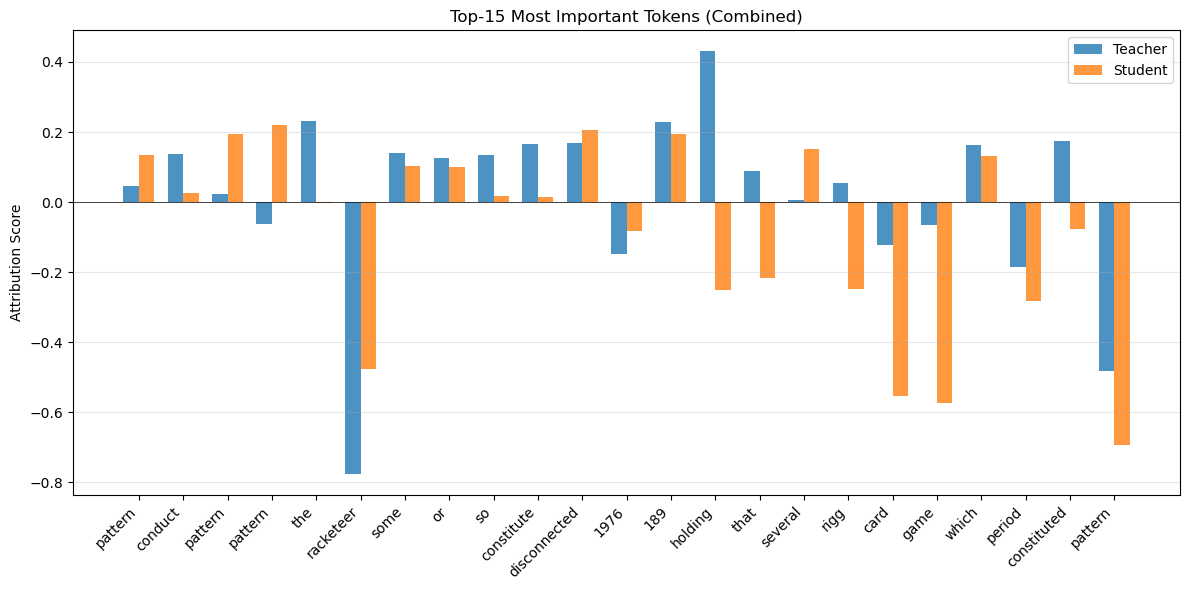

In [ ]:
# Visualize teacher attributions
print("\nComputing teacher attributions...")
teacher_attr = get_attributions(teacher_model, correct_input_ids, correct_attn_mask, method='ig')

print("\nComputing student attributions...")
student_attr = get_attributions(student_model, correct_input_ids, correct_attn_mask, method='ig')

# Filter tokens to keep only meaningful words
filtered_tokens, filtered_teacher, _ = filter_tokens_and_attributions(tokens, teacher_attr)
_, filtered_student, _ = filter_tokens_and_attributions(tokens, student_attr)

print(f"\nFiltered from {len(tokens)} to {len(filtered_tokens)} meaningful tokens")

# Show heatmap comparison (use top 30 meaningful tokens)
plot_attribution_heatmap(filtered_tokens, filtered_teacher, filtered_student, 
                         max_tokens=30, 
                         title=f"Example {example_num} - Attribution Comparison (Filtered)")

# Show bar chart of top tokens
plot_attribution_comparison_bars(filtered_tokens, filtered_teacher, filtered_student, top_k=15)

### Compare attributions

In [ ]:
# Correlation between teacher and student attributions
correlation = np.corrcoef(teacher_attr, student_attr)[0, 1]
print(f"Attribution correlation: {correlation:.3f}")

# Top-k overlap
k = 10
teacher_top = set(np.argsort(np.abs(teacher_attr))[-k:])
student_top = set(np.argsort(np.abs(student_attr))[-k:])
overlap = len(teacher_top & student_top) / k
print(f"Top-{k} token overlap: {overlap:.1%}")

Attribution correlation: 0.511
Top-10 token overlap: 60.0%


### Batch analysis across examples

In [ ]:
results = []

for idx in range(min(10, len(dev_sample))):
    example = dev_sample[idx]
    label = example['labels'].item()
    
    correct_input_ids = example['input_ids'][label]
    correct_attn_mask = example['attention_mask'][label]
    
    # Get attributions
    teacher_attr = get_attributions(teacher_model, correct_input_ids, correct_attn_mask, 'ig')
    student_attr = get_attributions(student_model, correct_input_ids, correct_attn_mask, 'ig')
    
    # Compute metrics
    corr = np.corrcoef(teacher_attr, student_attr)[0, 1]
    
    k = 10
    teacher_top = set(np.argsort(np.abs(teacher_attr))[-k:])
    student_top = set(np.argsort(np.abs(student_attr))[-k:])
    overlap = len(teacher_top & student_top) / k
    
    results.append({
        'example_idx': idx,
        'correlation': corr,
        'top10_overlap': overlap
    })
    
    print(f"Example {idx}: corr={corr:.3f}, overlap={overlap:.1%}")

results_df = pd.DataFrame(results)
print(f"\nAverage correlation: {results_df['correlation'].mean():.3f}")
print(f"Average top-10 overlap: {results_df['top10_overlap'].mean():.1%}")

Example 0: corr=0.397, overlap=30.0%
Example 1: corr=0.511, overlap=60.0%
Example 2: corr=0.605, overlap=50.0%
Example 3: corr=0.704, overlap=80.0%
Example 4: corr=0.599, overlap=40.0%
Example 5: corr=0.029, overlap=20.0%
Example 6: corr=0.659, overlap=50.0%
Example 7: corr=0.192, overlap=40.0%
Example 8: corr=0.744, overlap=50.0%
Example 9: corr=0.511, overlap=70.0%

Average correlation: 0.495
Average top-10 overlap: 49.0%


### Save results

In [ ]:
import os
os.makedirs('results/interpretability', exist_ok=True)

results_df.to_csv('results/interpretability/attribution_comparison.csv', index=False)
print("Results saved to results/interpretability/attribution_comparison.csv")

### Notes

Observations:
- High correlation suggests student learned similar reasoning
- Low overlap might indicate different focus even if correlation is high
- Need larger sample for statistical significance

Next steps:
- Expand to 50-100 examples
- Test other attribution methods (saliency, attention)
- Compare across different student sizes (PKD models)
- Analyze which tokens differ most

### EXPANDED ANALYSIS: Multi-Model Interpretability Study

The following cells implement comprehensive attribution analysis across all PKD student sizes.

In [ ]:
# Helper Function: Extract metadata from raw dataset
def extract_example_metadata(raw_example, label_idx):
    """
    Extract case facts and holdings from raw CSV dataset
    
    Args:
        raw_example: Single example from raw CSV dataset
        label_idx: The correct label index (0-4)
    
    Returns:
        dict with 'context', 'holdings', 'label'
    """
    metadata = {
        'context': raw_example['1'],  # Case facts from column 1
        'holdings': [
            raw_example['2'],  # Holding option 1
            raw_example['3'],  # Holding option 2
            raw_example['4'],  # Holding option 3
            raw_example['5'],  # Holding option 4
            raw_example['6'],  # Holding option 5
        ],
        'label': int(float(raw_example['12']))  # Correct answer
    }
    return metadata

In [ ]:
# Helper Function: Compute cosine similarity
def compute_cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two attribution vectors
    
    Args:
        vec1: First attribution vector (numpy array)
        vec2: Second attribution vector (numpy array)
    
    Returns:
        float: Cosine similarity score
    """
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Reshape for sklearn
    v1 = vec1.reshape(1, -1)
    v2 = vec2.reshape(1, -1)
    
    return cosine_similarity(v1, v2)[0, 0]

In [ ]:
# Helper Function: Save attribution heatmap to file
def save_attribution_heatmap(tokens, teacher_attr, student_attr, output_path, 
                            max_tokens=30, title="Attribution Comparison"):
    """
    Save side-by-side heatmap of teacher vs student attributions as PNG
    
    Args:
        tokens: List of token strings (already filtered)
        teacher_attr: Teacher attribution scores (numpy array)
        student_attr: Student attribution scores (numpy array)
        output_path: Path to save PNG file
        max_tokens: Maximum number of tokens to display
        title: Plot title
    """
    import matplotlib
    matplotlib.use('Agg')  # Non-interactive backend for saving files
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Truncate to max_tokens
    tokens = tokens[:max_tokens]
    teacher_attr = teacher_attr[:max_tokens]
    student_attr = student_attr[:max_tokens]
    
    # Normalize attributions to [-1, 1] for each model
    teacher_norm = teacher_attr / (np.abs(teacher_attr).max() + 1e-10)
    student_norm = student_attr / (np.abs(student_attr).max() + 1e-10)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), dpi=150)
    
    # Teacher heatmap
    teacher_data = teacher_norm.reshape(1, -1)
    sns.heatmap(teacher_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                xticklabels=tokens, yticklabels=['Teacher'], 
                cbar_kws={'label': 'Attribution'}, ax=ax1)
    ax1.set_title('Teacher Attributions', fontsize=14)
    ax1.set_xticklabels(tokens, rotation=90, fontsize=8)
    
    # Student heatmap
    student_data = student_norm.reshape(1, -1)
    sns.heatmap(student_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                xticklabels=tokens, yticklabels=['Student'], 
                cbar_kws={'label': 'Attribution'}, ax=ax2)
    ax2.set_title('Student Attributions', fontsize=14)
    ax2.set_xticklabels(tokens, rotation=90, fontsize=8)
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close(fig)  # Free memory

In [ ]:
# Helper Function: Save top-k combined tokens bar chart
def save_top15_bar_chart(tokens, teacher_attr, student_attr, output_path, top_k=15):
    """
    Save bar chart showing top-k most important tokens (combined) to PNG
    Filters out subword tokens and resolves ties by taking max absolute attribution
    
    Args:
        tokens: List of token strings (already filtered, no subwords)
        teacher_attr: Teacher attribution scores (numpy array)
        student_attr: Student attribution scores (numpy array)
        output_path: Path to save PNG file
        top_k: Number of top tokens to show
    """
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    
    # Get top-k indices for each model based on absolute attribution
    teacher_top_idx = np.argsort(np.abs(teacher_attr))[-top_k:][::-1]
    student_top_idx = np.argsort(np.abs(student_attr))[-top_k:][::-1]
    
    # Get union of top tokens
    all_top_idx = sorted(set(teacher_top_idx) | set(student_top_idx))
    
    # Tie resolution: for each token, take max absolute attribution
    combined_attrs = []
    for i in all_top_idx:
        teacher_val = teacher_attr[i]
        student_val = student_attr[i]
        # Take the value with larger absolute magnitude
        if abs(teacher_val) > abs(student_val):
            combined_attrs.append(teacher_val)
        else:
            combined_attrs.append(student_val)
    
    token_labels = [tokens[i] for i in all_top_idx]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
    
    x = np.arange(len(all_top_idx))
    width = 0.35
    
    teacher_vals = [teacher_attr[i] for i in all_top_idx]
    student_vals = [student_attr[i] for i in all_top_idx]
    
    ax.bar(x - width/2, teacher_vals, width, label='Teacher', alpha=0.8)
    ax.bar(x + width/2, student_vals, width, label='Student', alpha=0.8)
    
    ax.set_ylabel('Attribution Score', fontsize=10)
    ax.set_title(f'Top-{top_k} Most Important Tokens (Combined)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(token_labels, rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

### Test Helper Functions

In [ ]:
# Test 1: filter_tokens_and_attributions (already exists in notebook)
test_tokens = ['[CLS]', 'court', '##s', ',', 'held', 'that', '1']
test_attr = np.array([0.1, 0.5, 0.2, 0.05, 0.8, 0.3, 0.9])
filtered_t, filtered_a, _ = filter_tokens_and_attributions(test_tokens, test_attr)

assert 'court' in filtered_t, "Should keep 'court'"
assert 'held' in filtered_t, "Should keep 'held'"
assert 'that' in filtered_t, "Should keep 'that'"
assert '1' in filtered_t, "Should keep digit '1'"
assert '[CLS]' not in filtered_t, "Should remove [CLS]"
assert '##s' not in filtered_t, "Should remove subword ##s"
assert ',' not in filtered_t, "Should remove punctuation"

print("✓ filter_tokens_and_attributions works correctly")
print(f"  Filtered {len(test_tokens)} -> {len(filtered_t)} tokens")

# Test 2: compute_cosine_similarity
vec1 = np.array([1.0, 2.0, 3.0, 4.0])
vec2 = np.array([1.0, 2.0, 3.0, 4.0])
sim = compute_cosine_similarity(vec1, vec2)
assert abs(sim - 1.0) < 0.001, "Identical vectors should have similarity ~1.0"

vec3 = np.array([-1.0, -2.0, -3.0, -4.0])
sim2 = compute_cosine_similarity(vec1, vec3)
assert abs(sim2 - (-1.0)) < 0.001, "Opposite vectors should have similarity ~-1.0"

print("✓ compute_cosine_similarity works correctly")

# Test 3: extract_example_metadata
# Load raw dataset for testing
from datasets import load_dataset
dev_dataset_raw_test = load_dataset('csv', data_files={'dev': 'data/casehold/dev.csv'}, split='dev[:1]')
raw_ex = dev_dataset_raw_test[0]

metadata = extract_example_metadata(raw_ex, 0)
assert 'context' in metadata, "Should have context"
assert 'holdings' in metadata, "Should have holdings"
assert 'label' in metadata, "Should have label"
assert len(metadata['holdings']) == 5, "Should have 5 holdings"
assert isinstance(metadata['label'], int), "Label should be int"

print("✓ extract_example_metadata works correctly")
print(f"  Context preview: {metadata['context'][:100]}...")
print(f"  Holdings[0]: {metadata['holdings'][0][:80]}...")
print(f"  Label: {metadata['label']}")

print("\n✓✓✓ All helper function tests passed! ✓✓✓")

### Qualitative Analysis Function

Samples N examples and generates detailed visualizations and metadata for each.

In [ ]:
def run_qualitative_analysis(teacher_model, student_model, student_name,
                            dev_dataset_tokenized, dev_dataset_raw,
                            tokenizer, output_dir, n_samples=30, seed=42):
    """
    Sample n examples, generate visualizations, save metadata
    
    Args:
        teacher_model: 12-layer teacher model
        student_model: PKD student model (6/4/3/2 layer)
        student_name: e.g., "L6_B1000"
        dev_dataset_tokenized: Tokenized HF dataset (for attribution)
        dev_dataset_raw: Raw HF dataset (for metadata extraction)
        tokenizer: BERT tokenizer
        output_dir: Base results directory
        n_samples: Number of examples to sample
        seed: Random seed for reproducibility
    
    Creates:
        {output_dir}/{student_name}/qualitative_30_samples/sample_{idx:03d}/
            - metadata.json
            - attribution_heatmap_filtered.png
            - top15_tokens_combined.png
    """
    import random
    import json
    import os
    
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)
    
    # Sample indices
    total_examples = len(dev_dataset_tokenized)
    sampled_indices = random.sample(range(total_examples), n_samples)
    
    # Create output directory
    qual_dir = os.path.join(output_dir, student_name, 'qualitative_30_samples')
    os.makedirs(qual_dir, exist_ok=True)
    
    print(f"Processing {n_samples} examples for {student_name}...")
    
    for sample_num, idx in enumerate(sampled_indices):
        if sample_num % 5 == 0:
            print(f"  Progress: {sample_num}/{n_samples}")
        
        # Create sample directory
        sample_dir = os.path.join(qual_dir, f'sample_{sample_num:03d}')
        os.makedirs(sample_dir, exist_ok=True)
        
        # Get tokenized example
        example_tok = dev_dataset_tokenized[idx]
        label = example_tok['labels'].item()
        
        # Get raw example for metadata
        example_raw = dev_dataset_raw[idx]
        metadata = extract_example_metadata(example_raw, label)
        metadata['example_idx'] = idx
        metadata['sample_num'] = sample_num
        
        # Get correct choice tokens
        correct_input_ids = example_tok['input_ids'][label]
        correct_attn_mask = example_tok['attention_mask'][label]
        tokens = tokenizer.convert_ids_to_tokens(correct_input_ids)
        
        # Get attributions
        teacher_attr = get_attributions(teacher_model, correct_input_ids, correct_attn_mask, 'ig')
        student_attr = get_attributions(student_model, correct_input_ids, correct_attn_mask, 'ig')
        
        # Filter tokens
        filtered_tokens, filtered_teacher, _ = filter_tokens_and_attributions(tokens, teacher_attr)
        _, filtered_student, _ = filter_tokens_and_attributions(tokens, student_attr)
        
        # Save metadata
        metadata_path = os.path.join(sample_dir, 'metadata.json')
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        
        # Save filtered heatmap (top 30 meaningful tokens)
        heatmap_path = os.path.join(sample_dir, 'attribution_heatmap_filtered.png')
        save_attribution_heatmap(
            filtered_tokens, filtered_teacher, filtered_student,
            heatmap_path, max_tokens=30,
            title=f"{student_name} - Sample {sample_num} - Attribution Comparison"
        )
        
        # Save top-15 bar chart
        bar_path = os.path.join(sample_dir, 'top15_tokens_combined.png')
        save_top15_bar_chart(
            filtered_tokens, filtered_teacher, filtered_student,
            bar_path, top_k=15
        )
    
    print(f"✓ Qualitative analysis complete for {student_name}")
    print(f"  Saved {n_samples} examples to: {qual_dir}")

### Quantitative Analysis Function

Analyzes N examples and computes aggregate metrics (cosine similarity, correlation, top-k overlap).

In [ ]:
def run_quantitative_analysis(teacher_model, student_model, student_name,
                              dev_dataset_tokenized, tokenizer, output_dir,
                              n_samples=100, seed=42):
    """
    Analyze n examples, compute aggregate metrics
    
    Args:
        teacher_model: 12-layer teacher model
        student_model: PKD student model
        student_name: e.g., "L6_B1000"
        dev_dataset_tokenized: Tokenized HF dataset
        tokenizer: BERT tokenizer
        output_dir: Base results directory
        n_samples: Number of examples to analyze
        seed: Random seed
    
    Creates:
        {output_dir}/{student_name}/quantitative_100_samples.csv
        {output_dir}/{student_name}/summary_stats.txt
    
    Metrics per example:
        - Cosine similarity
        - Correlation coefficient
        - Top-10 overlap
    """
    import random
    import os
    
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)
    
    # Sample indices
    total_examples = len(dev_dataset_tokenized)
    sampled_indices = random.sample(range(total_examples), n_samples)
    
    # Create output directory
    quant_dir = os.path.join(output_dir, student_name)
    os.makedirs(quant_dir, exist_ok=True)
    
    print(f"Analyzing {n_samples} examples for {student_name}...")
    
    results = []
    
    for i, idx in enumerate(sampled_indices):
        if i % 10 == 0:
            print(f"  Progress: {i}/{n_samples}")
        
        # Get example
        example = dev_dataset_tokenized[idx]
        label = example['labels'].item()
        
        correct_input_ids = example['input_ids'][label]
        correct_attn_mask = example['attention_mask'][label]
        
        # Get attributions
        teacher_attr = get_attributions(teacher_model, correct_input_ids, correct_attn_mask, 'ig')
        student_attr = get_attributions(student_model, correct_input_ids, correct_attn_mask, 'ig')
        
        # Compute metrics
        # 1. Cosine similarity
        cosine_sim = compute_cosine_similarity(teacher_attr, student_attr)
        
        # 2. Correlation
        corr = np.corrcoef(teacher_attr, student_attr)[0, 1]
        
        # 3. Top-10 overlap
        k = 10
        teacher_top = set(np.argsort(np.abs(teacher_attr))[-k:])
        student_top = set(np.argsort(np.abs(student_attr))[-k:])
        overlap = len(teacher_top & student_top) / k
        
        results.append({
            'example_idx': idx,
            'cosine_similarity': cosine_sim,
            'correlation': corr,
            'top10_overlap': overlap
        })
    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    csv_path = os.path.join(quant_dir, 'quantitative_100_samples.csv')
    results_df.to_csv(csv_path, index=False)
    
    # Compute and save summary statistics
    summary_stats = {
        'cosine_similarity': {
            'mean': results_df['cosine_similarity'].mean(),
            'std': results_df['cosine_similarity'].std(),
            'min': results_df['cosine_similarity'].min(),
            'max': results_df['cosine_similarity'].max()
        },
        'correlation': {
            'mean': results_df['correlation'].mean(),
            'std': results_df['correlation'].std(),
            'min': results_df['correlation'].min(),
            'max': results_df['correlation'].max()
        },
        'top10_overlap': {
            'mean': results_df['top10_overlap'].mean(),
            'std': results_df['top10_overlap'].std(),
            'min': results_df['top10_overlap'].min(),
            'max': results_df['top10_overlap'].max()
        }
    }
    
    # Save summary to text file
    summary_path = os.path.join(quant_dir, 'summary_stats.txt')
    with open(summary_path, 'w') as f:
        f.write(f"Quantitative Analysis Summary: {student_name}\n")
        f.write(f"{'='*60}\n\n")
        f.write(f"Number of samples: {n_samples}\n\n")
        
        for metric, stats in summary_stats.items():
            f.write(f"{metric}:\n")
            f.write(f"  Mean: {stats['mean']:.4f}\n")
            f.write(f"  Std:  {stats['std']:.4f}\n")
            f.write(f"  Min:  {stats['min']:.4f}\n")
            f.write(f"  Max:  {stats['max']:.4f}\n\n")
    
    print(f"✓ Quantitative analysis complete for {student_name}")
    print(f"  Results saved to: {csv_path}")
    print(f"  Summary saved to: {summary_path}")
    
    # Print summary
    print(f"\n  Summary Statistics:")
    print(f"    Cosine Similarity: {summary_stats['cosine_similarity']['mean']:.4f} ± {summary_stats['cosine_similarity']['std']:.4f}")
    print(f"    Correlation:       {summary_stats['correlation']['mean']:.4f} ± {summary_stats['correlation']['std']:.4f}")
    print(f"    Top-10 Overlap:    {summary_stats['top10_overlap']['mean']:.4f} ± {summary_stats['top10_overlap']['std']:.4f}")
    
    return results_df

### Test Analysis Functions (Small Scale)

In [ ]:
# Test with n_samples=2 to verify everything works
print("Testing analysis functions with 2 samples...")

# Create test output directory
test_output_dir = "results/integrated_gradients_pkd_skip_results_TEST"
import os
os.makedirs(test_output_dir, exist_ok=True)

# Load raw dataset for testing
from datasets import load_dataset
dev_dataset_raw = load_dataset('csv', data_files={'dev': 'data/casehold/dev.csv'}, split='dev')

print(f"Loaded {len(dev_dataset)} tokenized examples")
print(f"Loaded {len(dev_dataset_raw)} raw examples")

# Use existing teacher and student models already loaded in notebook
print(f"\nUsing teacher model: {len(teacher_model.bert.encoder.layer)} layers")
print(f"Using student model: {len(student_model.bert.encoder.layer)} layers")

# Test qualitative analysis with 2 samples
print("\n" + "="*60)
print("TEST 1: Qualitative Analysis (n=2)")
print("="*60)
run_qualitative_analysis(
    teacher_model, student_model, "TEST_L6",
    dev_dataset, dev_dataset_raw, tokenizer,
    test_output_dir, n_samples=2, seed=42
)

# Verify files were created
qual_dir = os.path.join(test_output_dir, "TEST_L6", "qualitative_30_samples")
assert os.path.exists(qual_dir), "Qualitative directory should exist"

sample_0_dir = os.path.join(qual_dir, "sample_000")
assert os.path.exists(sample_0_dir), "Sample 000 should exist"
assert os.path.exists(os.path.join(sample_0_dir, "metadata.json")), "metadata.json should exist"
assert os.path.exists(os.path.join(sample_0_dir, "attribution_heatmap_filtered.png")), "Heatmap should exist"
assert os.path.exists(os.path.join(sample_0_dir, "top15_tokens_combined.png")), "Bar chart should exist"

print("\n✓ Qualitative test passed - all files created successfully!")

# Test quantitative analysis with 2 samples  
print("\n" + "="*60)
print("TEST 2: Quantitative Analysis (n=2)")
print("="*60)
results_df = run_quantitative_analysis(
    teacher_model, student_model, "TEST_L6",
    dev_dataset, tokenizer,
    test_output_dir, n_samples=2, seed=42
)

# Verify outputs
quant_dir = os.path.join(test_output_dir, "TEST_L6")
assert os.path.exists(os.path.join(quant_dir, "quantitative_100_samples.csv")), "CSV should exist"
assert os.path.exists(os.path.join(quant_dir, "summary_stats.txt")), "Summary should exist"
assert len(results_df) == 2, "Should have 2 results"

print("\n✓ Quantitative test passed!")

print("\n" + "="*60)
print("✓✓✓ ALL TESTS PASSED ✓✓✓")
print("="*60)
print("\nReady to run full analysis on all student models!")

### Multi-Model Runner: Analyze All PKD Students

Run comprehensive analysis across all 4 PKD student sizes (6, 4, 3, 2 layers).

In [ ]:
# Configuration
output_base = "results/integrated_gradients_pkd_skip_results"
import os
os.makedirs(output_base, exist_ok=True)

# Load both tokenized and raw datasets
from datasets import load_dataset

# Tokenized dataset (for attribution)
datasets_tokenized = get_dataloaders(tokenizer, return_dict=True)
dev_dataset_tokenized = datasets_tokenized['dev']

# Raw dataset (for metadata extraction)
dev_dataset_raw = load_dataset('csv', data_files={'dev': 'data/casehold/dev.csv'}, split='dev')

print(f"Loaded {len(dev_dataset_tokenized)} dev examples")

# Student model configurations
student_configs = [
    {"name": "L6_B1000", "path": "results/training_runs/pkd_skip_grid_search/pkd_skip_L6_B1000/checkpoint-3975", "layers": 6},
    {"name": "L4_B100", "path": "results/training_runs/pkd_skip_grid_search/pkd_skip_L4_B100/checkpoint-3975", "layers": 4},
    {"name": "L3_B1000", "path": "results/training_runs/pkd_skip_grid_search/pkd_skip_L3_B1000/checkpoint-5300", "layers": 3},
    {"name": "L2_B500", "path": "results/training_runs/pkd_skip_grid_search/pkd_skip_L2_B500/checkpoint-5300", "layers": 2},
]

# Process each student model
for config in student_configs:
    print(f"\n{'='*60}")
    print(f"Processing {config['name']} ({config['layers']} layers)")
    print(f"{'='*60}")
    
    # Load student model
    student_model = AutoModelForMultipleChoice.from_pretrained(config['path']).to(device).eval()
    print(f"Loaded student model: {config['path']}")
    
    # Run qualitative analysis
    print("\n[1/2] Running qualitative analysis (30 samples)...")
    run_qualitative_analysis(teacher_model, student_model, config['name'],
                             dev_dataset_tokenized, dev_dataset_raw,
                             tokenizer, output_base, n_samples=30)
    
    # Run quantitative analysis
    print("\n[2/2] Running quantitative analysis (100 samples)...")
    run_quantitative_analysis(teacher_model, student_model, config['name'],
                              dev_dataset_tokenized, tokenizer, output_base,
                              n_samples=100)
    
    # Free memory
    del student_model
    torch.cuda.empty_cache()
    print(f"\n✓ Completed {config['name']}")

print("\n" + "="*60)
print("✓✓✓ ALL ANALYSES COMPLETE! ✓✓✓")
print("="*60)
print(f"\nResults saved to: {output_base}")
print("\nNext: Run cross-model comparison to aggregate results")

### Cross-Model Comparison

Aggregate quantitative results across all student sizes for comparative analysis.

In [ ]:
# Combine quantitative results across all student sizes
all_results = []

for config in student_configs:
    csv_path = os.path.join(output_base, config['name'], 'quantitative_100_samples.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df['student_name'] = config['name']
        df['num_layers'] = config['layers']
        all_results.append(df)
        print(f"Loaded {len(df)} results for {config['name']}")
    else:
        print(f"WARNING: {csv_path} not found - skipping")

# Combine into single DataFrame
combined_df = pd.concat(all_results, ignore_index=True)
combined_path = os.path.join(output_base, 'comparison_across_sizes.csv')
combined_df.to_csv(combined_path, index=False)

print(f"\n✓ Combined {len(combined_df)} total results")
print(f"  Saved to: {combined_path}")

# Summary statistics by student size
summary = combined_df.groupby(['student_name', 'num_layers']).agg({
    'cosine_similarity': ['mean', 'std'],
    'correlation': ['mean', 'std'],
    'top10_overlap': ['mean', 'std']
}).round(4)

print("\n" + "="*60)
print("SUMMARY BY STUDENT SIZE")
print("="*60)
print(summary)

# Save summary
summary_path = os.path.join(output_base, 'summary_by_size.csv')
summary.to_csv(summary_path)
print(f"\n✓ Summary saved to: {summary_path}")

# Create a more readable text summary
readable_summary_path = os.path.join(output_base, 'summary_readable.txt')
with open(readable_summary_path, 'w') as f:
    f.write("Cross-Model Attribution Comparison Summary\n")
    f.write("="*60 + "\n\n")
    
    for config in student_configs:
        subset = combined_df[combined_df['student_name'] == config['name']]
        f.write(f"{config['name']} ({config['layers']} layers)\n")
        f.write("-" * 40 + "\n")
        f.write(f"  Cosine Similarity: {subset['cosine_similarity'].mean():.4f} ± {subset['cosine_similarity'].std():.4f}\n")
        f.write(f"  Correlation:       {subset['correlation'].mean():.4f} ± {subset['correlation'].std():.4f}\n")
        f.write(f"  Top-10 Overlap:    {subset['top10_overlap'].mean():.4f} ± {subset['top10_overlap'].std():.4f}\n\n")

print(f"✓ Readable summary saved to: {readable_summary_path}")

print("\n" + "="*60)
print("✓✓✓ CROSS-MODEL COMPARISON COMPLETE! ✓✓✓")
print("="*60)